## MICROBIOME DATA EXPLORATION PIPELINE
#### THIS CODE SHOWS HOW TO USE CLASSES IN ExploreTS.py to analyse microbiome data for further use

#### STEPS
##### 1. series visualization using X 
##### 2. testing for stationarity with TestStationarity()
##### 3. making data stationarity with MakeSeriesStationary()
##### 4. testing for autocorrelation with AutoCorrelation()
##### 5. testing for Granger causality with GrengerCausality

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns

import os
import sys

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf

In [2]:
MODULE_PATH = os.path.abspath('/storage/zkarwowska/clean_code/data_preparation/') 
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

from ProcessingFunctions import CLRTransformer

MODULE_PATH = os.path.abspath('/storage/zkarwowska/clean_code/data_exploration//') 
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

from ExploreTS import TestStationarity, AutoCorrelation, GrengerCausality, MakeSeriesStationary

In [3]:
names = ['asv1',
         'asv2',
         'asv3']


counts = np.array([[ 0.,  10.,  12.],
                   [19.,  20.,  10.],
                   [ 0.,  22.,  3.],
                   [26.,  35.,  3.],
                   [ 8.,  18.,  55.],
                   [ 0.,  0.,  60.],
                   [13.,  0.,  65.],
                   [ 0.,  0.,  60.],
                   [13.,  0.,  65.],
                   [ 0.,  0.,  60.],
                   [13.,  0.,  65.],
                   [ 4.,  3.,  70.],
                   [ 0.,  0.,  30.],
                   [ 0.,  12.,  25.]])

df = pd.DataFrame(counts, columns = names)

#### 0. TRANSFORM DATA WITH CLR TO GET RID OF COMPOSITIONALITY

In [4]:
clr_transformer = CLRTransformer(is_pseudo_global=True, axis=1)
df_clr = clr_transformer.fit_transform(df)

#### 1. TIME SERIES VISUALIZATION

<AxesSubplot:>

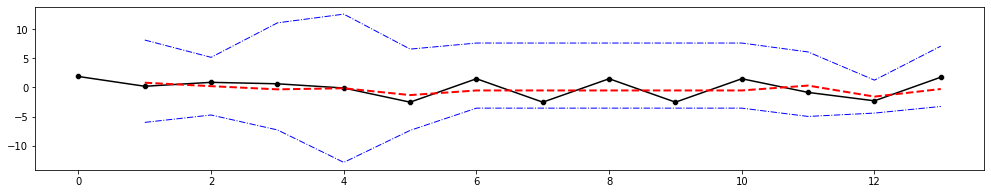

In [5]:
window = 2
rol_mean = df_clr.rolling(window = window).median().median(axis=1)
rol_std_p = (df_clr.rolling(window = window).median() + df.rolling(window = window).std()).median(axis=1)
rol_std_n = (df_clr.rolling(window = window).median() - df.rolling(window = window).std()).median(axis=1)

mean_true = df_clr.median(axis=1)

plt.figure(figsize = [17, 3])

sns.lineplot(x=mean_true.index, y=mean_true.values, color = 'black')
sns.scatterplot(x=mean_true.index, y=mean_true.values, color = 'black')

sns.lineplot(x=rol_mean.index, y=rol_mean.values, color = 'red', linewidth = 2, linestyle ='--')
sns.lineplot(x=rol_std_p.index, y=rol_std_p.values, color = 'blue', linewidth = 1, linestyle = '-.')
sns.lineplot(x=rol_std_n.index, y=rol_std_n.values, color = 'blue', linewidth = 1, linestyle = '-.')

#### 2. TEST IF TIME SERIES IS STATIONARY

verify whether series is stationary (has stable mean and variance over time) using Augmented Dickey–Fuller (unit root) test and KPSS test (deterministic trend)

In [6]:
test_stat = TestStationarity()

# adf test
adf_results = test_stat.calculate_adf(df_clr)
adf_results

,adf_pval,feature,adf_stationarity
0,0.994648,asv1,non-stationary
1,0.160490,asv2,non-stationary
2,0.000113,asv3,stationary


In [7]:
# kpss test
kpss_results = test_stat.calculate_kpss(df_clr)
kpss_results

/home/MCB/zkarwowska/anaconda3/envs/var_env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


,kpss_pval,feature,kpss_stationarity
0,0.010000,asv1,non-stationary
1,0.022103,asv2,non-stationary
2,0.079691,asv3,stationary


#### 3. MAKE SERIES STATIONARY
make series stationary by differencing or detrending

In [8]:
make_stat = MakeSeriesStationary()
df_diff = make_stat.difference(df_clr)
df_detrend = make_stat.remove_trend(df_clr)

/home/MCB/zkarwowska/anaconda3/envs/var_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/MCB/zkarwowska/anaconda3/envs/var_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'DIFFERENCED TIME SERIES')

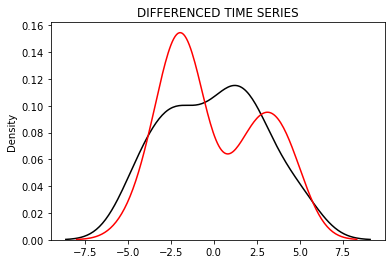

In [9]:
sns.distplot(df_clr, hist=False, color = 'black')
sns.distplot(df_diff, hist=False, color = 'red')
plt.title('DIFFERENCED TIME SERIES')

/home/MCB/zkarwowska/anaconda3/envs/var_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/MCB/zkarwowska/anaconda3/envs/var_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'DETRENDED TIME SERIES')

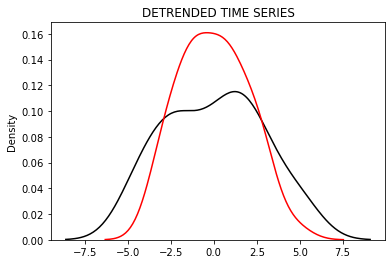

In [10]:
sns.distplot(df_clr, hist=False, color = 'black')
sns.distplot(df_detrend, hist=False, color = 'red')
plt.title('DETRENDED TIME SERIES')

#### 4. TEST AUTOCORRELATION

test if variable is autocorrelated in time

In [11]:
autocorr = AutoCorrelation(lags = 3)

## acf
autocorr.calculate_acf(df_clr)

,coeff,pvalues,lag,feature
0,-0.483099,0.044926,1,asv1
1,0.433154,0.023241,2,asv1
2,-0.282813,0.027331,3,asv1
0,0.499443,0.038155,1,asv2
1,0.609367,0.003644,2,asv2
2,-0.022337,0.010498,3,asv2
0,0.409454,0.089198,1,asv3
1,0.369460,0.065980,2,asv3
2,0.121247,0.125176,3,asv3


In [12]:
## pacf
autocorr.calculate_pacf(df_clr)

,coeff,lags,feature
1,-0.548696,1,asv1
2,0.156993,2,asv1
3,-0.188270,3,asv1
1,0.514389,1,asv2
2,0.474435,2,asv2
3,-0.685446,3,asv2
1,0.380193,1,asv3
2,0.249133,2,asv3
3,-0.080830,3,asv3


### 5. GRANGER CAUSALITY ANALYSIS
analyse if variables Granger cause each other

In [13]:
granger = GrengerCausality()
#caluclate granger statistics
granger_df = granger.test_granger(df_clr)
granger_df.head()

,effect_size,pvalues,asv1,asv2,lag
0,0.0000,1.0000,asv1,asv1,1
1,0.0000,1.0000,asv1,asv1,2
0,0.7899,0.3741,asv1,asv2,1
1,0.7338,0.6929,asv1,asv2,2
0,0.7899,0.3741,asv1,asv3,1


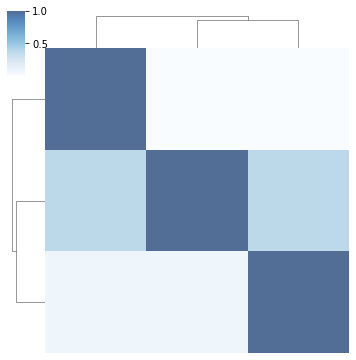

In [16]:
#change results into a matrix
ganger_matrix = granger.to_matrix(granger_df)
#plot using clustermap
granger.plot_clustermap(ganger_matrix)